# Introduction

The aim of this demo is to demonstrate the functionality of the **mri-spire** package.

## Quantitative MRI

In quantitative MRI the image acquisition sequence is setup in such a way as to acquire a series of images at different values of a specific controlled experimental parameter. This gives a third dimension to the collected data called the parameter encoding dimension. In a TSE sequence the controlled parameter is the Echo Time (TE).

The goal of qMRI is to obtain a quantitative map i.e. an image in which each voxel has a corresponding value of a physical parameter specific to the tissue at that voxel and affecting the MR signal profile at that location. This is obtained by fitting a model to the intensity profile of each voxel along the series of images.

The process is illustrated in the figure below for a T2 mapping experiment where the T2 decay observed in each voxel is approximated by an exponential decay model. The T2 value obtained in each voxel is then mapped to that specific location.
![](qmri.png)

## Compressed Sensing (CS)

The MRI data is traditionally acquired in k-space (the Fourier Transform of the image space) on a cartesian grid in such a way that the number of data points is equal to the number of voxels. This obeys the Nyquist sampling rule. The reconstruction of the MR images is then equivalent to solving a determined system of linear equations. Intuitively this means that for each bit of information (voxel intensity) in the final image there needs to be a data point acquired in k-space.

In natural images, there is a lot of redundancy coming from the correlations between the voxels e.g. adjacent voxels can form patches of almost identical intensity values. This redundancy is exploited in compression techniques such as the JPEG standard. The sparsity concept refers to the fact that under a specific transforms an image has a sparse representation i.e. with very few  non-zero values. Storing only those values is the mechanism behind compression. 

Sparsity can also be applied in MRI reconstruction to accelerate the acquisition process through the technique of Compressed Sensing. There exists some prior knowledge about the sparsity of an image, which can be used to compensate for missing information when less data is collected and the Nyquist limit is broken. Mathematically, the reconstruction now corresponds to an underdetermined system of linear equations which is solved using regularization.

## Sparse Iterative Reconstruction

The mri-spire package provides a framework for the design of CS reconstruction algorithms that exploit the sparsity of the signal in each of voxel along the parameter encoding dimension. This means it exploits the correlation of the intensity values of a voxel along the series of images.

At a high level the algorithm applies the following loop iteratively:
![](algorithm_loop.png)

- The data consistency step makes sure the k-space data that was collected is consistent with that of the reconstruction. 
- The sparsifying step applies the prior knowledge about the sparsity of the reconstructed signals in the form of a **signal sparse representation**.

### Detailed diagram of the SpIRe algorithm
![](algorithm_detailed.png)

# Demo

The Demo shows an example of image reconstruction for a TSE sequence where the signal in each voxel is T2 decay.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
import scipy.io as sio
import pickle

import mrispire as mrsp

### Creating synthetic MRI series data

First we need to create some simulated image data. This can be achieved by providing a signal model and a phantom of T2 values.

In [2]:
# load exponential model data split into test and train sets

with open('dataset_exponential01.pickle','rb') as pckl_file:
    dataset_exp = pickle.load(pckl_file)
    
T2_train = dataset_exp['T2_train']
T2_test = dataset_exp['T2_test']
TE_values = dataset_exp['TE_values']
data_train = dataset_exp['data_train']
data_test = dataset_exp['data_test']

The signal model is given by exponential decay. A dataset representing the model was created before and loaded. 

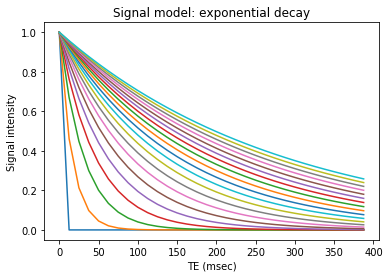

In [3]:
# preview of the signal model

plt.figure()
plt.plot(TE_values, data_test[:, np.arange(0, data_test.shape[1], 50)])
plt.xlabel("TE (msec)");
plt.ylabel("Signal intensity");
plt.title("Signal model: exponential decay");

Image size: 256
T2 values of compartments: [ 11.95  71.35 130.75 190.45 249.85] msec


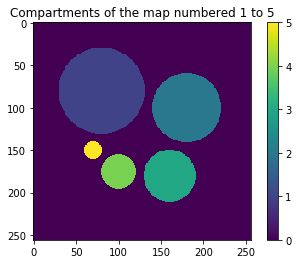

In [4]:
# create a new image series using the circles phantom provided by the package

# set up phantom
# parameters to set: T2, image size
im_size = 256 #256x256
# choose 5 T2 of interest from the test values to use in phantom
indx_T2_range = np.nonzero((T2_test > 12.1) & (T2_test < 250.3))[0]
# select 5 values uniformly from the range chosen above
indx_T2_compartments = indx_T2_range[np.round(np.linspace(0, len(indx_T2_range)-1, 5)).astype(int)]
print("Image size:", im_size)
print('T2 values of compartments:', T2_test[indx_T2_compartments-1], "msec")

phantom_ind = mrsp.phantom_circles(im_size)
plt.imshow(phantom_ind); plt.colorbar();
plt.title("Compartments of the map numbered 1 to 5");

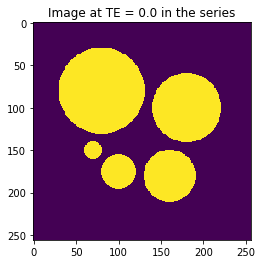

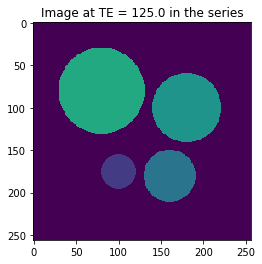

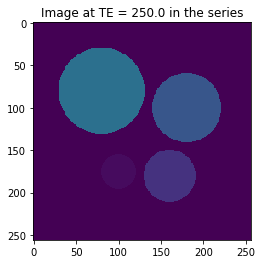

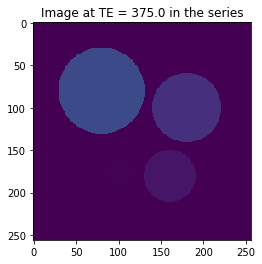

In [5]:
# make 3D phantom
signals = np.hstack((np.zeros((data_test.shape[0], 1)), data_test))
indx_signals = np.append(0, np.flip(indx_T2_compartments))
phantom = signals[:, indx_signals[phantom_ind]]

# show image series
for i in [0, 10, 20, 30]:
    plt.figure();
    plt.imshow(phantom[i], vmin=0, vmax=1);
    plt.title("Image at TE = "+str(TE_values[i])+" in the series")

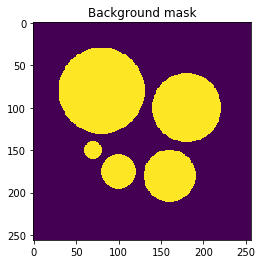

In [6]:
# make im space and mask
im_space = phantom
background_mask = np.full(phantom_ind.shape, True)
background_mask[phantom_ind == 0] = False

plt.imshow(background_mask);
plt.title("Background mask");

### Storing qMRI data in the form of ImageSeries

The package manipulates MRI data in the form of ImageSeries objects.

Now that we have some synthetic qMRI image series data we can create an ImageSeries object.

In [7]:
# create ImageSeries

image_series = mrsp.ImageSeries(im_space, background_mask, 
                                p_values=TE_values)

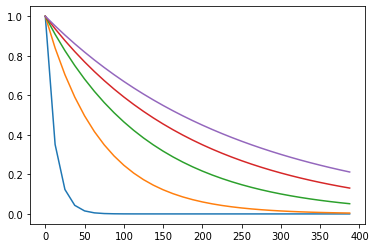

In [8]:
# plot the unique voxel shapes

plt.plot(TE_values, np.unique(image_series.voxels_masked(), axis=1));

We can get the k-space of all the images in the series just by using the k-space attribute.

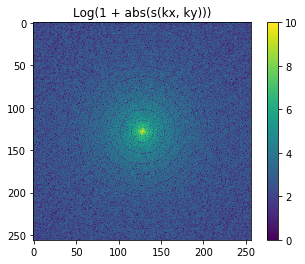

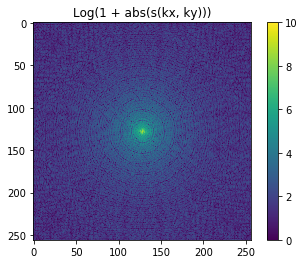

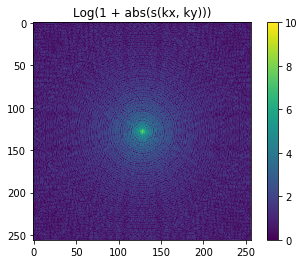

In [9]:
# plot the k-space of a few slices in absolute value

for i in [0, 15, 30]:
    plt.figure();
    plt.imshow(np.log(1 + np.abs(image_series.k_space[i,:,:])),
               vmin=0, vmax=10);
    plt.colorbar();
    plt.title('Log(1 + abs(s(kx, ky)))');

### Creating UndersampledSeries objects

UndersampledSeries objects contain undersampled k-space data. They can be obtain by undersampling existing complete ImageSeries objects.

To undersample we need a sampling mask for the k-space.

In [10]:
# import k-space mask with pseudo-random sampling based on a Halton sequence

# load MATLAB file containing sampling mask
mat_file = sio.loadmat('Halton_mask_4X_10rows.mat')
# extract the sampling mask
samp_mask_2d = np.array(mat_file['mask'], dtype=bool)
# create a 3d sampling mask by repeating the 2d mask along the kx dimension
mask = np.moveaxis(samp_mask_2d, -1, 0)
mask = np.tile(mask[:, :, np.newaxis], im_space.shape[2])

This mask is pseudo-randomly sampled along the ky and TE dimensions and fully sampled along kx.

Text(0.5, 0, 'kx dimension')

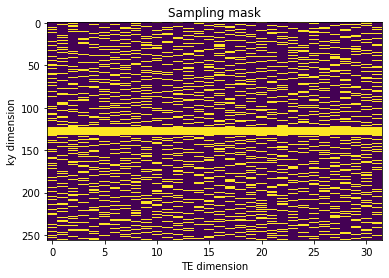

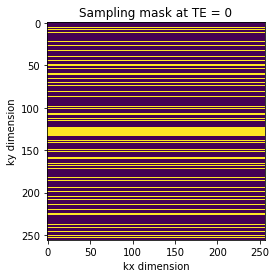

In [11]:
plt.figure();
plt.imshow(mask[:, :, 0].T);
plt.title("Sampling mask")
plt.ylabel("ky dimension")
plt.xlabel("TE dimension")
plt.axis('auto');

plt.figure();
plt.imshow(mask[0, :, :]);
plt.title("Sampling mask at TE = 0")
plt.ylabel("ky dimension")
plt.xlabel("kx dimension")

In [12]:
# undersample the k-space of the image series 4 times by
# applying the mask to the complete series

undersamp_series = mrsp.UndersampledSeries.from_complete_series(
    image_series, mask
)

The undersampled series automatically fills the missing k-space values with zeros.

Undersampling factor: 4.0


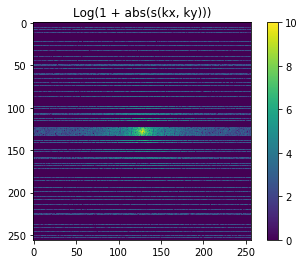

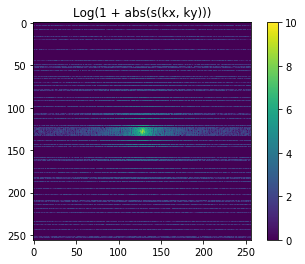

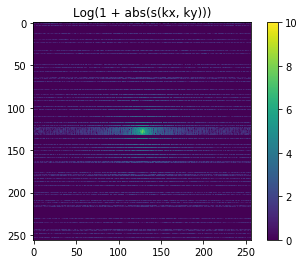

In [13]:
# check undersampled series

print("Undersampling factor: "+str(undersamp_series.undersampling_factor))

for i in [0, 15, 30]:
    plt.figure();
    plt.imshow(np.log(1 + np.abs(undersamp_series.k_space[i,:,:])),
               vmin=0, vmax=10);
    plt.colorbar();
    plt.title('Log(1 + abs(s(kx, ky)))');

The image space of the undersampled series has aliasing artifacts due to undersampling.

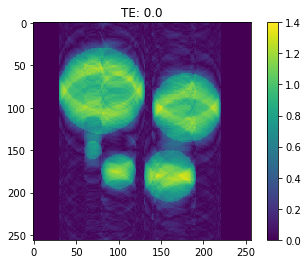

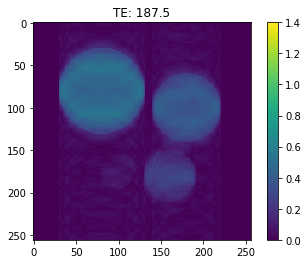

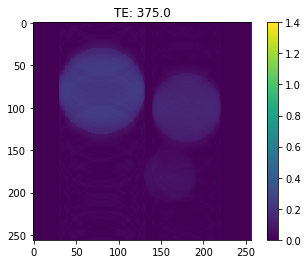

In [14]:
# show the aliasing artifacts

for i in [0, 15, 30]:
    plt.figure();
    plt.imshow(np.abs(undersamp_series.image_space[i,:,:]),
               vmin=0, vmax=1.4);
    plt.colorbar();
    plt.title('TE: '+str(TE_values[i]));

### Creating a sparse representation of the decay signal

The sparse iterative reconstruction needs a way to sparsify the signals to remove the undersampling artifacts. This is provided by a method to sparsely represent the signals.

In this Demo the Principal Components (PC) representation is used. Given a model of the signal shape in the form of train data, any signal should be sparsely represented by a linear combination of a few of the PCs of the train data.

The PrincipalComponents class can learn the PCs of any given data and then represent new signals as a combination of the PCs.

In [15]:
# create a 3 PC representation of the exponential model given 
# by the signals in the train data matrix

pc_rep = mrsp.PrincipalComponents(n_rep=3, train_data=data_train)

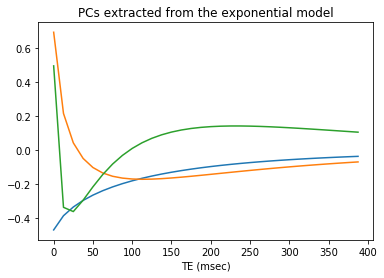

In [16]:
# visualize the PCs

plt.figure()
plt.plot(TE_values, pc_rep.pcs)
plt.xlabel("TE (msec)");
plt.title("PCs extracted from the exponential model");

Other sparse representations available in the package are the K-SVD Dictionary and the Grid Database.

### Reconstructing the image series using the SparseReconstructor object 

The reconstruction removes the undersampling artifacts using a sparse representation of the signals. The previously created PC representation is used here.

To track the progress of the reconstruction during the iterations, a listener object can be triggered to analyze the reconstruction after each step. Here, a DistanceRecorder instance will keep track of the error/distance of the reconstructed image series from the fully sampled image series. A storer is also created to store all the intermediate reconstructed images in a 4D array.

In [17]:
# create a DistanceRecorder instance to keep track of error of reconstruction from the ground truth

dist_recorder = mrsp.DistanceRecorder(ref_points=[image_series])
storer = mrsp.Storer()

In [18]:
# create a SparseReconstructor instance and attach the dist_recorder and the storers as listeners to the reconstruction
pc_rep.sparse_th = 0

reconstructor = mrsp.SparseReconstructor(sparse_representation=pc_rep, 
                                         n_iter=30, 
                                         rec_analyzers=[dist_recorder, storer])

In [19]:
%%time
# carry out the reconstruction

reconstructed_series = reconstructor.reconstruct(undersampled_series=undersamp_series)

Wall time: 30.4 s


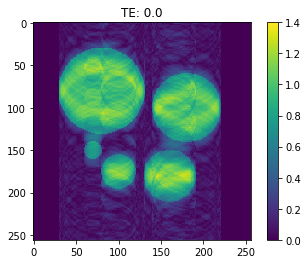

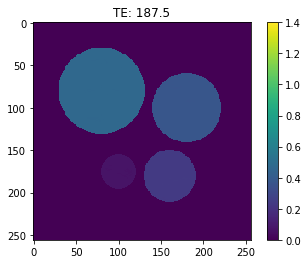

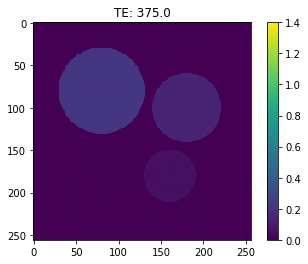

In [20]:
# show the reconstructed image space

for i in [0, 15, 30]:
    plt.figure();
    plt.imshow(np.abs(reconstructed_series.image_space[i,:,:]),
               vmin=0, vmax=1.4);
    plt.colorbar();
    plt.title('TE: '+str(TE_values[i]));

In [21]:
# interactive plot
from bokeh.plotting import output_notebook, show

output_notebook()
bok_vis = mrsp.BokehStorerVis(storer, image_series)
show(bok_vis.modify_doc, notebook_url="http://localhost:8888" )

Loading BokehJS ...

The artifacts have clearly disappeared for long TE values. Let's check the evolution of the error during the iterations.

RMSE of reconstruction: 0.027856765039441678


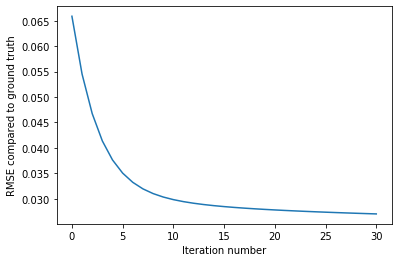

In [22]:
# plot the RMSE against iteration number using the DistanceRecorder

plt.figure();
plt.plot(dist_recorder.step_rec, dist_recorder.dist_ref_to_rec[0]);
plt.ylabel("RMSE compared to ground truth");
plt.xlabel("Iteration number");

print("RMSE of reconstruction: "+str(dist_recorder.dist_ref_to_proj[0, -1]))

Try to improve the reconstrcution by using a sparsity threshold on the PC coefficients.

In [23]:
pc_rep.sparse_th = 0.1

reconstructor = mrsp.SparseReconstructor(sparse_representation=pc_rep, 
                                         n_iter=30, 
                                         rec_analyzers=[dist_recorder, storer])

In [24]:
%%time
# carry out the reconstruction

reconstructed_series = reconstructor.reconstruct(undersampled_series=undersamp_series)

Wall time: 28.8 s


RMSE of reconstruction: 0.013696073480731121


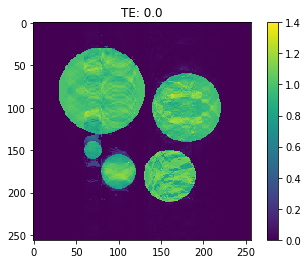

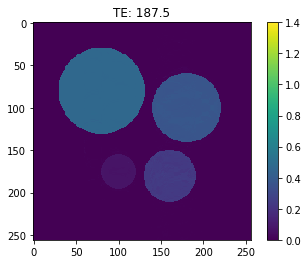

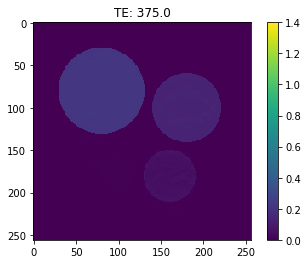

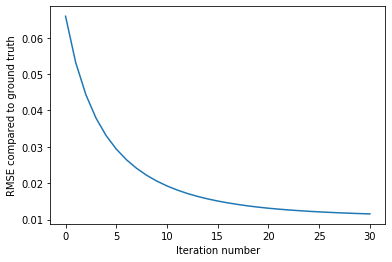

In [25]:
# show the reconstructed image space

for i in [0, 15, 30]:
    plt.figure();
    plt.imshow(np.abs(reconstructed_series.image_space[i,:,:]),
               vmin=0, vmax=1.4);
    plt.colorbar();
    plt.title('TE: '+str(TE_values[i]));
    
# plot the RMSE against iteration number using the DistanceRecorder

plt.figure();
plt.plot(dist_recorder.step_rec, dist_recorder.dist_ref_to_rec[0]);
plt.ylabel("RMSE compared to ground truth");
plt.xlabel("Iteration number");

print("RMSE of reconstruction: "+str(dist_recorder.dist_ref_to_proj[0, -1]))

Using a threshold increased the accuracy because the reconstruction overfitted the aliasing artifacts at the low TE values less than in the previous test.